<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Hallucination Classification Evals</h1>

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to detecting hallucinations,
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [7]:
#####################
## N_EVAL_SAMPLE_SIZE
#####################
# Eval sample size determines the run time
# 100 samples: GPT-4 ~ 80 sec / GPT-3.5 ~ 40 sec
# 1,000 samples: GPT-4 ~15-17 min / GPT-3.5 ~ 6-7min (depending on retries)
# 10,000 samples GPT-4 ~170 min / GPT-3.5 ~ 70min
N_EVAL_SAMPLE_SIZE = 100

In [1]:
!pip install -qq "arize-phoenix[experimental]" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken

In [2]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
from phoenix.experimental.evals import (
    HALLUCINATION_PROMPT_RAILS_MAP,
    HALLUCINATION_PROMPT_TEMPLATE,
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of an LLM model and settings in addition to an evaluation prompt template against benchmark datasets of queries and retrieved documents with ground-truth relevance labels. Currently supported datasets include "halueval_qa_data" from the HaluEval benchmark:

- https://arxiv.org/abs/2305.11747
- https://github.com/RUCAIBox/HaluEval

In [3]:
df = download_benchmark_dataset(
    task="binary-hallucination-classification", dataset_name="halueval_qa_data"
)
df.head()

,reference,query,response,is_hallucination
0,"() is a prefecture-level city in northwestern Anhui province, China.Gaozhou is a county-level city in southwestern Guangdong Province, China.",Can Fuyang and Gaozhou be found in the same province?,no,False
1,"() is a prefecture-level city in northwestern Anhui province, China.Gaozhou is a county-level city in southwestern Guangdong Province, China.",Can Fuyang and Gaozhou be found in the same province?,"Yes, Fuyang and Gaozhou are in the same province.",True
2,"""808"" was a success in the United States becoming the group's first top ten hit peaking at number eight on the ""Billboard"" Hot 100 and top five peaking at number four on the Hot R&B/Hip-Hop Singles.The ""Billboard"" Hot 100 is the music industry standard record chart in the United States for singles, published weekly by ""Billboard"" magazine.",808 peaked at number eight on what?,"Billboard"" Hot 100",False
3,"""808"" was a success in the United States becoming the group's first top ten hit peaking at number eight on the ""Billboard"" Hot 100 and top five peaking at number four on the Hot R&B/Hip-Hop Singles.The ""Billboard"" Hot 100 is the music industry standard record chart in the United States for singles, published weekly by ""Billboard"" magazine.",808 peaked at number eight on what?,"""808"" peaked at number nine on ""Billboard"" Hot 100.",True
4,"""Arms"" then made a comeback in 2017 reaching #36 on the iTunes chart passing Auli'i Cravalho's ""How Far I'll Go"" from the Disney movie ""Moana"" (2017).Moana ( ) is a 2016 American 3D computer-animated musical fantasy-adventure film produced by Walt Disney Animation Studios and released by Walt Disney Pictures.","Arms is a song by American singer-songwriter Christina Perri, in 2017, it passed Auli'i Cravalho's, ""How Far I'll Go"" from which 2016, American 3D computer-animated Disney movie?",Moana,False


## Display Binary Hallucination Classification Template

View the default template used to classify hallucinations. You can tweak this template and evaluate its performance relative to the default.

In [4]:
print(HALLUCINATION_PROMPT_TEMPLATE)


In this task, you will be presented with a query, a reference text and an answer. The answer is
generated to the question based on the reference text. The answer may contain false information, you
must use the reference text to determine if the answer to the question contains false information,
if the answer is a hallucination of facts. Your objective is to determine whether the reference text
contains factual information and is not a hallucination. A 'hallucination' in this context refers to
an answer that is not based on the reference text or assumes information that is not available in
the reference text. Your response should be a single word: either "factual" or "hallucinated", and
it should not include any other text or characters. "hallucinated" indicates that the answer
provides factually inaccurate information to the query based on the reference text. "factual"
indicates that the answer to the question is correct relative to the reference text, and does not
contain made up inf

Template variables:
- **query** : The question or prompt asked on the context data.
- **reference** : The context data used to answer the question
- **answer** : The answer from the context data, we are checking this answer for halluciations relative to the reference context

## Configure the LLM

Configure your OpenAI API key.

In [5]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

## Benchmark Dataset Sample
Sample size determines run time
Recommend iterating small: 100 samples
Then increasing to large test set

In [8]:
df = df.sample(n=N_EVAL_SAMPLE_SIZE).reset_index(drop=True)

## LLM Evals: hallucination Classifications GPT-4
Run hallucination against a subset of the data.

Instantiate the LLM and set parameters.

In [9]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

In [10]:
model("Hello world, this is a test if you are working?")

"Hello! I'm working perfectly. How can I assist you today?"

In [11]:
# The rails fore the output to specific values of the template
# It will remove text such as ",,," or "...", anything not the
# binary value expected from the template
rails = list(HALLUCINATION_PROMPT_RAILS_MAP.values())
hallucination_classifications = llm_classify(
    dataframe=df, template=HALLUCINATION_PROMPT_TEMPLATE, model=model, rails=rails
)["label"]

  0%|          | 0/100 [00:00<?, ?it/s]



Evaluate the predictions against human-labeled ground-truth hallucination labels.

              precision    recall  f1-score   support

hallucinated       0.94      0.77      0.85        57
     factual       0.75      0.93      0.83        43

    accuracy                           0.84       100
   macro avg       0.85      0.85      0.84       100
weighted avg       0.86      0.84      0.84       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

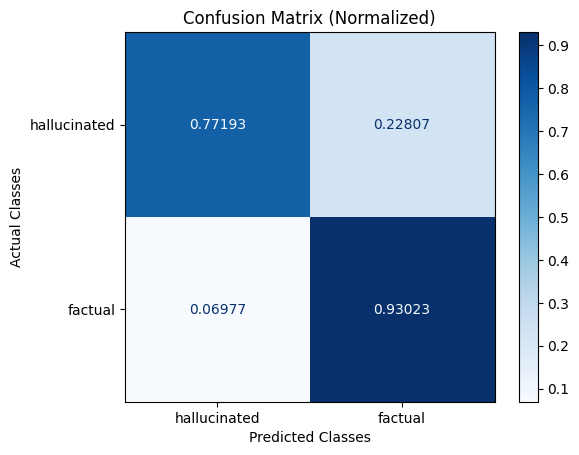

In [12]:
true_labels = df["is_hallucination"].map(HALLUCINATION_PROMPT_RAILS_MAP).tolist()
hallucination_classifications = (
    pd.Series(hallucination_classifications)
    .map(lambda x: "unparseable" if x is None else x)
    .tolist()
)
print(classification_report(true_labels, hallucination_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=hallucination_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Classifications with explanations

When evaluating a dataset for hallucinations, it can be useful to know why the LLM classified a response as a hallucination or not. The following code block runs `llm_classify` with explanations turned on so that we can inspect why the LLM made the classification it did. There is speed tradeoff since more tokens is being generated but it can be highly informative when troubleshooting.

In [15]:
small_df_sample = df.copy().sample(n=5).reset_index(drop=True)
hallucination_classifications_df = llm_classify(
    dataframe=small_df_sample,
    template=HALLUCINATION_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    provide_explanation=True,
    verbose=True,
)

OpenAI invocation parameters: {'model': 'gpt-3.5-turbo', 'temperature': 0.0, 'max_tokens': 256, 'frequency_penalty': 0, 'presence_penalty': 0, 'top_p': 1, 'n': 1, 'timeout': 20}


  0%|          | 0/5 [00:00<?, ?it/s]

- Snapped 'factual' to rail: factual
- Snapped 'hallucinated' to rail: hallucinated
- Snapped 'hallucinated' to rail: hallucinated
- Snapped 'hallucinated' to rail: hallucinated
- Snapped 'hallucinated' to rail: hallucinated


In [16]:
# Let's view the data
merged_df = pd.merge(
    small_df_sample, hallucination_classifications_df, left_index=True, right_index=True
)
merged_df[["query", "reference", "response", "is_hallucination", "label", "explanation"]].head()

,query,reference,response,is_hallucination,label,explanation
0,"The 2009 Baylor Bears football team represented Baylor University in the 2009 NCAA Division I FBS football season, the team was coached by Arthur Ray Briles, is an American football coach and former player, is an American football coach and former player, Briles was formerly the head coach at Baylor University from 2008 through what year, from which he was fired in the wake of a major sexual assault scandal?","The team was coached by Art Briles. Briles was formerly the head coach at Baylor University from 2008 through 2015, from which he was fired in the wake of a major sexual assault scandal in his football program.",2015,False,factual,"The answer '2015' is factual based on the reference text. The reference text states that Art Briles was the head coach at Baylor University from 2008 through 2015, and he was fired in the wake of a major sexual assault scandal."
1,What was the name of the keyboardist and songwriter who formed the electronic music group whose fifth studio album was Invaders Must Die?,"Invaders Must Die is the fifth studio album by English electronic dance music group The Prodigy.The Prodigy are an English electronic music group from Braintree, Essex, formed in 1990 by keyboardist and songwriter Liam Howlett.",Liam Howlett was the one who composed Electra Heart.,True,hallucinated,"The answer is hallucinated because it states that Liam Howlett composed Electra Heart, which is not mentioned in the reference text."
2,"Which genus contains more species, Dacrydium or Araiostegia?","Dacrydium is a genus of conifers belonging to the podocarp family Podocarpaceae. Sixteen species of evergreen dioecious trees and shrubs are presently recognized. The revisions of de Laubenfels and Quinn (see references), reclassified the former section A as the new genus ""Falcatifolium"", divided Section C into new genera ""Lepidothamnus, Lagarostrobos"" and ""Halocarpus"", and retained Section B as genus ""Dacrydium"".Araiostegia is a genus of twelve epiphytic or terrestrial ferns from tropical Asia belonging to the hares-foot fern family.",Araiostegia has more species than Dacrydium.,True,hallucinated,"The reference text states that Dacrydium has 16 recognized species, while Araiostegia is described as a genus of twelve ferns. Therefore, the answer that Araiostegia has more species than Dacrydium is factually inaccurate."
3,Did both Battle of Chancellorsville and Battle of Pusan Perimeter take place on the same continent?,"The Battle of Chancellorsville was a major battle of the American Civil War (1861–1865), and the principal engagement of the Chancellorsville Campaign.The Battle of Pusan Perimeter was a large-scale battle between United Nations and North Korean forces lasting from August 4 to September 18, 1950.","Yes, both battles occurred on different continents.",True,hallucinated,"The answer is hallucinated because the reference text states that the Battle of Chancellorsville took place during the American Civil War, which was fought in North America, while the Battle of Pusan Perimeter took place during the Korean War, which was fought in Asia. Therefore, the two battles occurred on the same continent, which contradicts the answer."
4,The Bee Gees were a music group that was formed in 1958. Where was their album released in?,"Kitty Can was the compilation album released by the Bee Gees, released only in South America on RSO Records.were a pop music group formed in 1958.",Kitty Can was released in Europe.,True,hallucinated,"The answer is hallucinated because the reference text states that the album 'Kitty Can' was released only in South America, not in Europe."


## LLM Evals: hallucination Classifications GPT-3.5
Run hallucination against a subset of the data.

In [13]:
model = OpenAIModel(model_name="gpt-3.5-turbo", temperature=0.0, request_timeout=20)

In [14]:
rails = list(HALLUCINATION_PROMPT_RAILS_MAP.values())
hallucination_classifications = llm_classify(
    dataframe=df, template=HALLUCINATION_PROMPT_TEMPLATE, model=model, rails=rails
)["label"]

  0%|          | 0/100 [00:00<?, ?it/s]

              precision    recall  f1-score   support

hallucinated       0.88      0.63      0.73        57
     factual       0.64      0.88      0.75        43

    accuracy                           0.74       100
   macro avg       0.76      0.76      0.74       100
weighted avg       0.78      0.74      0.74       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

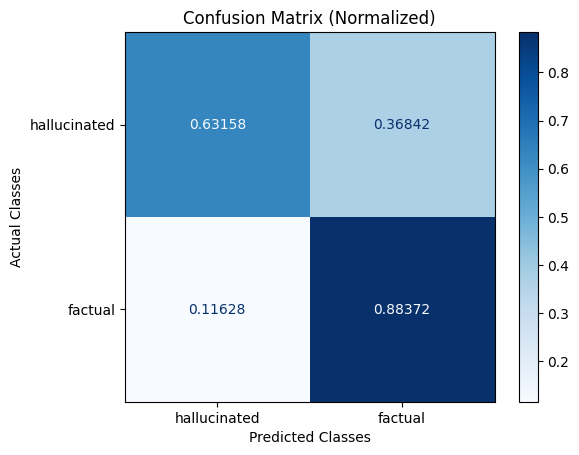

In [17]:
true_labels = df["is_hallucination"].map(HALLUCINATION_PROMPT_RAILS_MAP).tolist()
hallucination_classifications = (
    pd.Series(hallucination_classifications)
    .map(lambda x: "unparseable" if x is None else x)
    .tolist()
)

print(classification_report(true_labels, hallucination_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=hallucination_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

# Preview: GPT-4 Turbo

In [ ]:
rails = list(HALLUCINATION_PROMPT_RAILS_MAP.values())
readability_classifications = llm_classify(
    dataframe=df,
    template=HALLUCINATION_PROMPT_TEMPLATE,
    model=OpenAIModel(model_name="gpt-4-1106-preview", temperature=0.0),
    rails=rails,
)["label"]

In [ ]:
true_labels = df["is_hallucination"].map(HALLUCINATION_PROMPT_RAILS_MAP).tolist()
hallucination_classifications = (
    pd.Series(hallucination_classifications)
    .map(lambda x: "unparseable" if x is None else x)
    .tolist()
)

print(classification_report(true_labels, hallucination_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=hallucination_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)